In [2]:
import torch
import cv2
import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

In [2]:
# Inverse DCT and reconstruct the channels
def inverse_dct(coeffs):
    return idct(idct(coeffs.T, norm='ortho').T, norm='ortho')

In [3]:
def inverse_dct(coeffs):
    return idct(idct(coeffs.T, type=2, norm='ortho').T, type=2, norm='ortho')

def process_image(x0_img):
    # Scale to 0-255 and convert to uint8
    x0_scaled = ((x0_img + 1) / 2 * 255).clamp(0, 255).byte().cpu().numpy()

    # Convert to YCrCb
    ycrcb = cv2.cvtColor(x0_scaled, cv2.COLOR_RGB2YCrCb).astype(np.float32)

    # Reshape the image into 8×8 patches for vectorized operations
    patches_lum = ycrcb[:, :, 0].reshape(4, 8, 4, 8).swapaxes(1, 2).reshape(-1, 8, 8)
    patches_cr = ycrcb[:, :, 1].reshape(4, 8, 4, 8).swapaxes(1, 2).reshape(-1, 8, 8)
    patches_cb = ycrcb[:, :, 2].reshape(4, 8, 4, 8).swapaxes(1, 2).reshape(-1, 8, 8)

    # Apply DCT in parallel
    dct_lum = np.array([dct(dct(p.T, norm='ortho').T, norm='ortho') for p in patches_lum])
    dct_cr = np.array([dct(dct(p.T, norm='ortho').T, norm='ortho') for p in patches_cr])
    dct_cb = np.array([dct(dct(p.T, norm='ortho').T, norm='ortho') for p in patches_cb])

    # Apply masks
    dct_lum *= ~lum_mask
    dct_cr *= ~chro_cr_mask
    dct_cb *= ~chro_cb_mask

    # Inverse DCT in parallel
    recon_lum = np.array([inverse_dct(p) for p in dct_lum])
    recon_cr = np.array([inverse_dct(p) for p in dct_cr])
    recon_cb = np.array([inverse_dct(p) for p in dct_cb])

    # Reconstruct the image from patches
    reconstructed_lum = recon_lum.reshape(4, 4, 8, 8).swapaxes(1, 2).reshape(32, 32)
    reconstructed_cr = recon_cr.reshape(4, 4, 8, 8).swapaxes(1, 2).reshape(32, 32)
    reconstructed_cb = recon_cb.reshape(4, 4, 8, 8).swapaxes(1, 2).reshape(32, 32)

    # Stack channels and convert back to RGB
    reconstructed_ycrcb = np.stack([reconstructed_lum, reconstructed_cr, reconstructed_cb], axis=-1).astype(np.uint8)
    reconstructed_rgb = cv2.cvtColor(reconstructed_ycrcb, cv2.COLOR_YCrCb2RGB)

    # Normalize back to -1 to 1
    return torch.tensor((reconstructed_rgb / 255.0 - 0.5) * 2, dtype=torch.float32, device=x0_img.device)

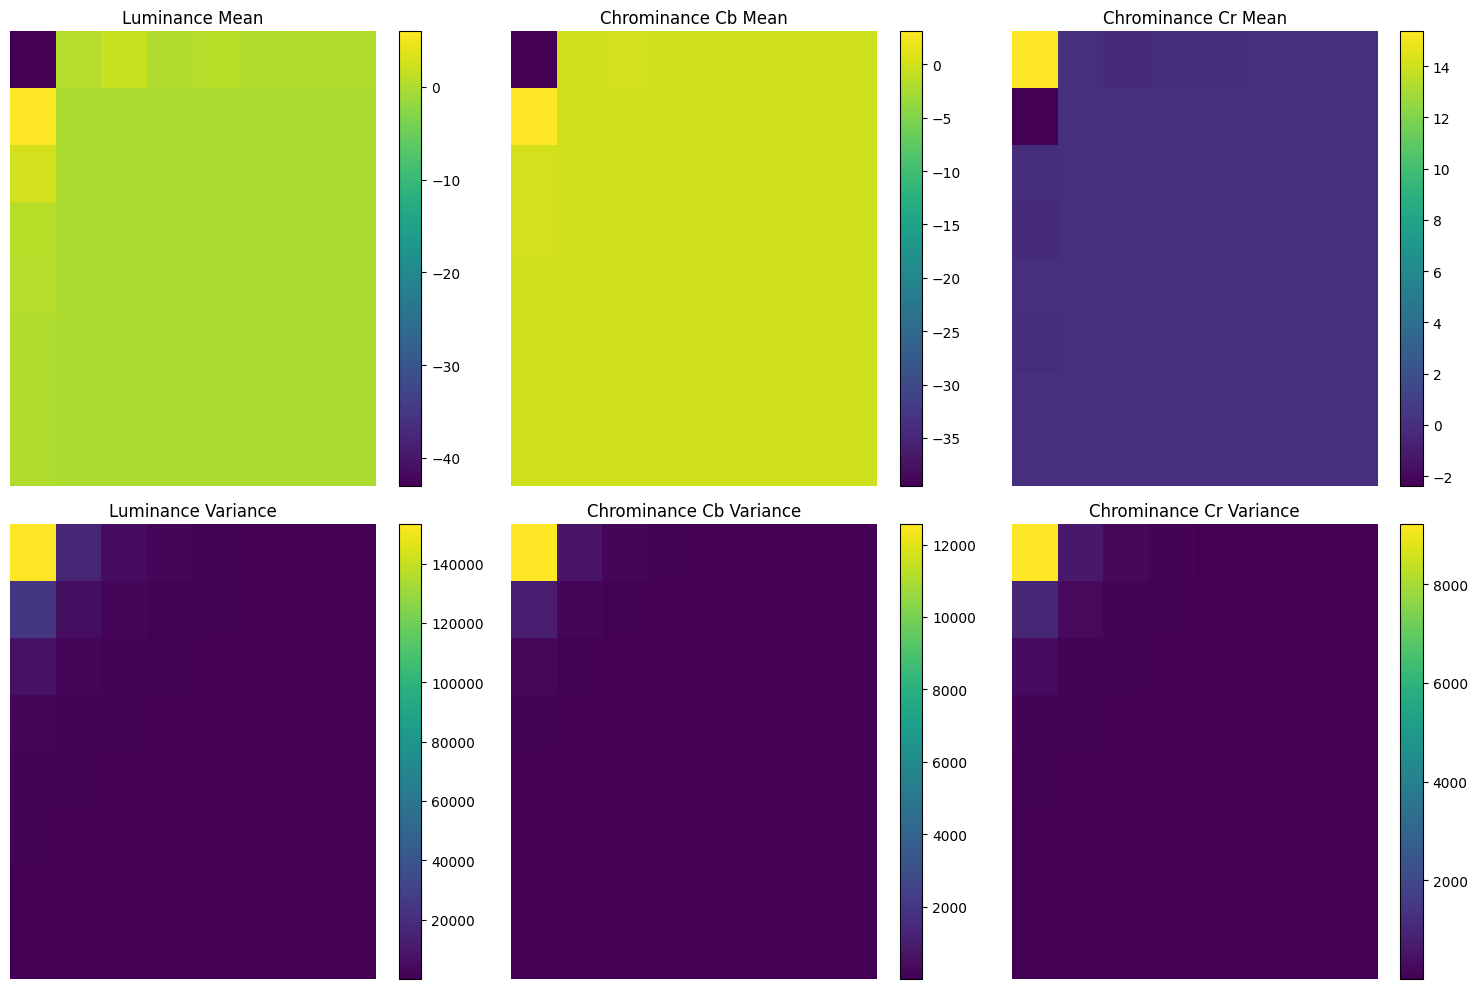

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# read npy and visualize

luminance_mean = np.load('stats/luminance_mean.npy')
luminance_var = np.load('stats/luminance_var.npy')
chrominance_cb_mean = np.load('stats/chrominance_cb_mean.npy')
chrominance_cb_var = np.load('stats/chrominance_cb_var.npy')
chrominance_cr_mean = np.load('stats/chrominance_cr_mean.npy')
chrominance_cr_var = np.load('stats/chrominance_cr_var.npy')

# visualize the means and variances with heatmap
# means as 1 x 3 
# variances as 1 x 3

# List of data and titles for easier plotting
data_list = [
    (luminance_mean, "Luminance Mean"),
    (chrominance_cb_mean, "Chrominance Cb Mean"),
    (chrominance_cr_mean, "Chrominance Cr Mean"),
    (luminance_var, "Luminance Variance"),
    (chrominance_cb_var, "Chrominance Cb Variance"),
    (chrominance_cr_var, "Chrominance Cr Variance")
]

# Plot the heatmaps
plt.figure(figsize=(15, 10))
for i, (data, title) in enumerate(data_list, 1):
    plt.subplot(2, 3, i)
    plt.imshow(data, cmap='viridis', aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()


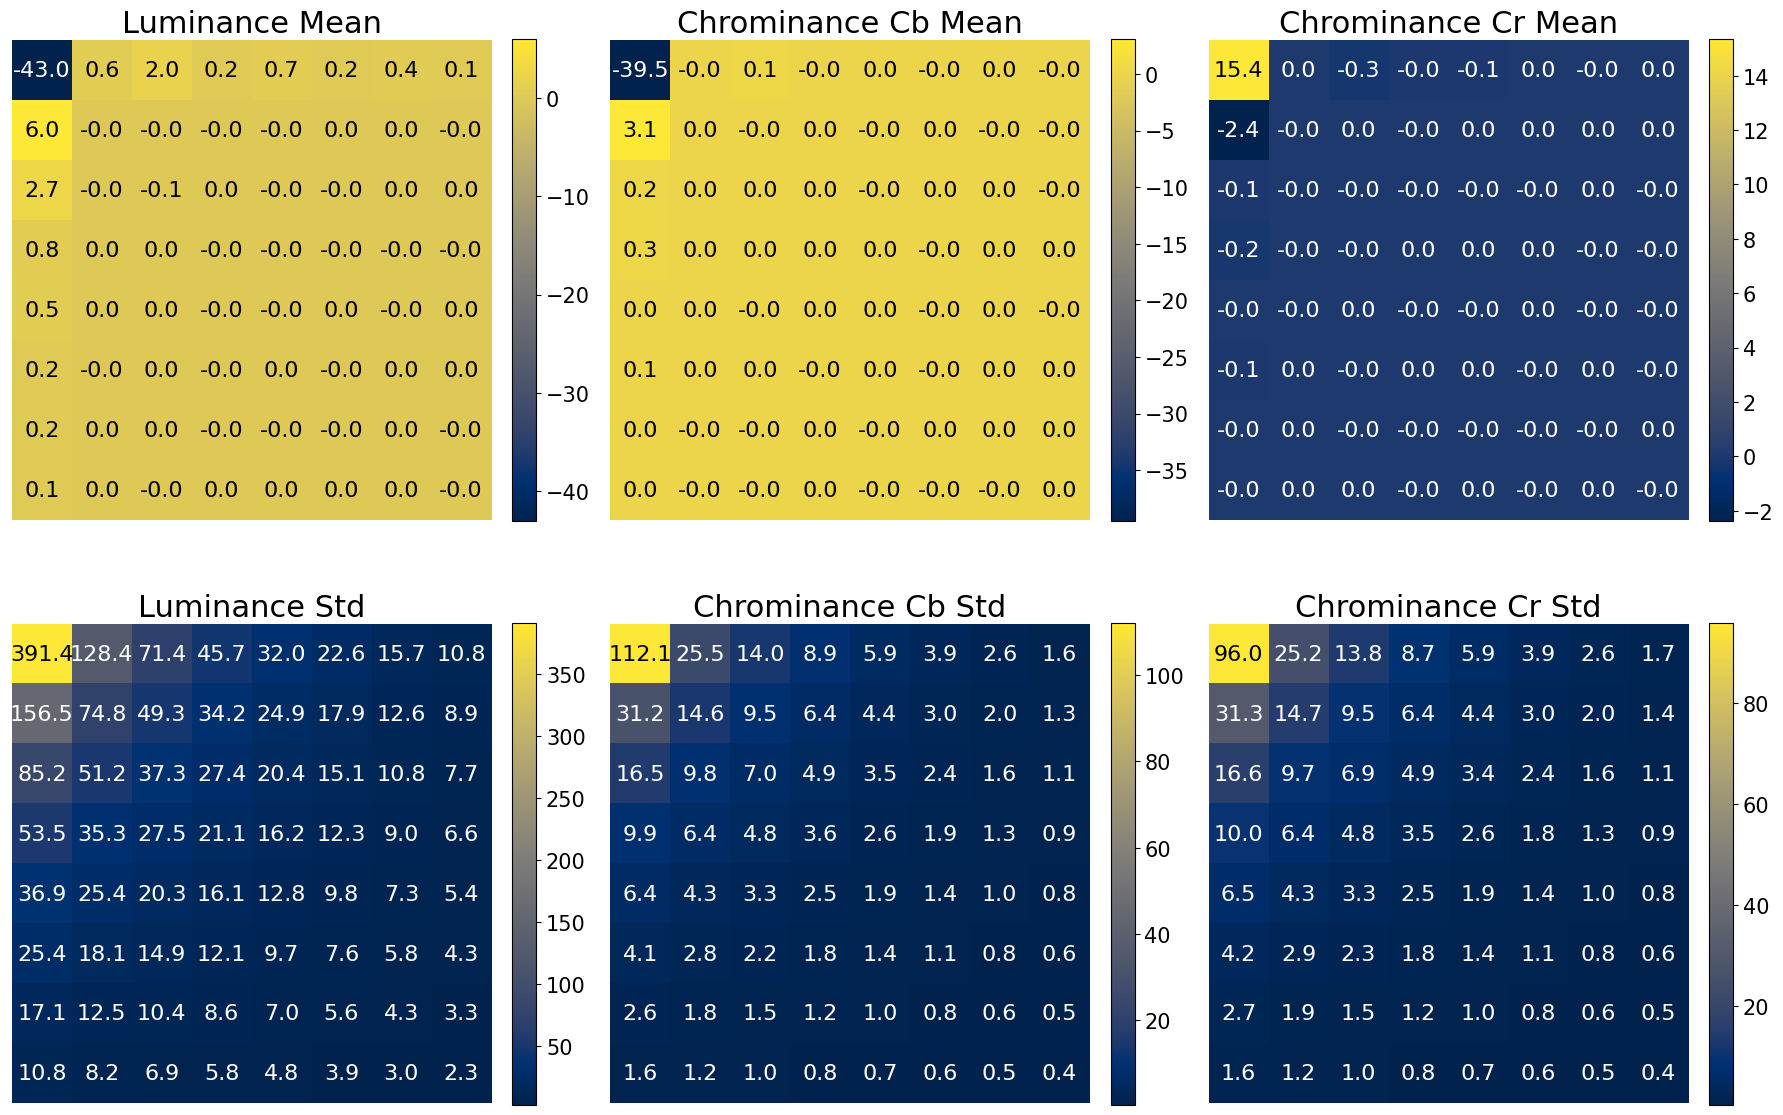

In [32]:
# List of data and titles for easier plotting
data_list2 = [
    (luminance_mean, "Luminance Mean"),
    (chrominance_cb_mean, "Chrominance Cb Mean"),
    (chrominance_cr_mean, "Chrominance Cr Mean"),
    (np.sqrt(luminance_var), "Luminance Std"),
    (np.sqrt(chrominance_cb_var), "Chrominance Cb Std"),
    (np.sqrt(chrominance_cr_var), "Chrominance Cr Std")
]

plt.figure(figsize=(18, 12))
for i, (data, title) in enumerate(data_list2, 1):
    ax = plt.subplot(2, 3, i)
    im = ax.imshow(data, cmap='cividis')

    # Annotate each cell with the value
    for (j, k), val in np.ndenumerate(data):
        ax.text(k, j, f'{val:.1f}', ha='center', va='center', color='white' if val < data.max() - (data.max() - data.min())/2 else 'black', fontsize=16)

    ax.set_title(title, fontsize=22)
    ax.tick_params(labelsize=15)
    ax.axis('off')
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.show()